<a href="https://colab.research.google.com/github/Induwara24/Rose-Hearts/blob/main/Rose_Hearts_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get data from google drive
!gdown --id 1YxLmo9Nw5bLOGErfNkoWqUlEyWf2Rsq8

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1YxLmo9Nw5bLOGErfNkoWqUlEyWf2Rsq8
From (redirected): https://drive.google.com/uc?id=1YxLmo9Nw5bLOGErfNkoWqUlEyWf2Rsq8&confirm=t&uuid=2f09da1a-f5d0-490d-9333-cace75f2bfbb
To: /content/Mammogram_Dataset_KAU.zip
100% 606M/606M [00:05<00:00, 106MB/s] 


In [3]:
# unzip the folder
!unzip /content/Mammogram_Dataset_KAU.zip

Archive:  /content/Mammogram_Dataset_KAU.zip
   creating: Mammogram_Dataset_KAU/
   creating: Mammogram_Dataset_KAU/Benign/
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC003026_ CC_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC003026_ CC_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC003026_ MLO_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC003026_ MLO_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC009941_ CC_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC009941_ CC_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC009941_ MLO_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC009941_ MLO_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC010562_ CC_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC010562_ CC_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC010562_ MLO_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC010562_ MLO_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC01118

In [4]:
# Install necessary libraries (if not already installed)
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00


In [40]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import shutil
import glob
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [7]:
# count the number of mammograms in the respective classes
ROOT_DIR = "/content/Mammogram_Dataset_KAU"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

print("Number of images in each class:", number_of_images)

Number of images in each class: {'Malignant': 124, 'Normal': 1865, 'Benign': 387}


##Spliting the data;
- 70% for train data
- 15% for test data
- 15% for validation data

In [8]:
# create a function to split the data into separate folders
def splitDataFolder(path, split):
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./"+path+"/"+dir, exist_ok=True)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir)), size=math.floor(split*number_of_images[dir]), replace=False):
      O = os.path.join(ROOT_DIR, dir, img)
      D = os.path.join("./"+path, dir)
      shutil.copy(O, D)
      os.remove(O)

In [9]:
# create the train folder
splitDataFolder("train", 0.7)

In [10]:
# create the validation folder
splitDataFolder("val", 0.15)

In [11]:
# create the test folder
splitDataFolder("test", 0.15)

## Class weighting

In [12]:
# Calculate class weights for imbalanced dataset
def get_class_weights():
    # Get all classes
    class_names = list(number_of_images.keys())
    # Get class frequencies
    class_counts = list(number_of_images.values())
    # Encode class names
    le = LabelEncoder()
    class_indices = le.fit_transform(class_names)
    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(class_indices),
        y=class_indices
    )
    # Create dictionary mapping class indices to weights
    weights = {i: weight for i, weight in enumerate(class_weights)}
    return weights

In [13]:
class_weights = get_class_weights()
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


## Data preprocessing

In [14]:
# Preprocessing for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

In [15]:
# Preprocessing for validation and test data (just rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

## Loading data

In [16]:
# Load the train data
train_data = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

Found 1661 images belonging to 3 classes.


In [17]:
# Load the validation data
val_data = val_test_datagen.flow_from_directory(
    '/content/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 355 images belonging to 3 classes.


In [18]:
# Load the test data
test_data = val_test_datagen.flow_from_directory(
    '/content/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 355 images belonging to 3 classes.


In [19]:
# Print class indices to understand the order
print("Class indices:", train_data.class_indices)

Class indices: {'Benign': 0, 'Malignant': 1, 'Normal': 2}


# Model build

In [20]:
# Build the model using EfficientNetB3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [21]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes: Normal, Benign, Malignant

In [22]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,217,458 (42.79 MB)

 Trainable params: 430,339 (1.64 MB)

 Non-trainable params: 10,787,119 (41.15 MB)

In [25]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [26]:
# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='efficientnet_mammogram_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

## Model training

In [27]:
# Train the model (initial training with frozen layers)
initial_history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=10,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    class_weight=class_weights
)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.6195 - loss: 1.0382 - precision: 0.6492 - recall: 0.5502
Epoch 1: val_accuracy improved from -inf to 0.78592, saving model to efficientnet_mammogram_model.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6203 - loss: 1.0367 - precision: 0.6499 - recall: 0.5512 - val_accuracy: 0.7859 - val_loss: 0.7404 - val_precision: 0.7859 - val_recall: 0.7859 - learning_rate: 0.0010
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.7248 - loss: 0.8220 - precision: 0.7408 - recall: 0.6870
Epoch 2: val_accuracy did not improve from 0.78592
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 707ms/step - accuracy: 0.7248 - loss: 0.8217 - precision: 0.7409 - recall: 0.6871 - val_accuracy: 0.7859 - val_loss: 0.6507 - val_precision: 0.7859 - val_recall: 0.7859 - learning_rate: 0.0010
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.7535 - loss: 0.7344 - precision: 0.7659 - recall: 0.7356
Epoch 3: val_accuracy did not improve from 0.78592
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 714ms/step - accuracy: 0.7535 - loss: 0.7345 - precision: 0.7659 - recall: 0.7356 - val_accuracy: 0.7859 - val_loss: 0.6608 - val_precision: 0.7859 - val_recall: 0.7

## Fine tuning

In [29]:
# Fine-tuning phase
print("Starting fine-tuning phase...")

Starting fine-tuning phase...


In [30]:
# Unfreeze some layers of the base model for fine-tuning
# We'll unfreeze the top 50% of the base model layers
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [31]:
# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [32]:
# Train again with fine-tuning
fine_tune_history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=15,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    class_weight=class_weights
)

Epoch 1/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.7529 - loss: 0.7618 - precision_1: 0.7763 - recall_1: 0.7166
Epoch 1: val_accuracy did not improve from 0.78592
104/104 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7529 - loss: 0.7613 - precision_1: 0.7764 - recall_1: 0.7166 - val_accuracy: 0.7859 - val_loss: 0.6537 - val_precision_1: 0.7859 - val_recall_1: 0.7859 - learning_rate: 1.0000e-04
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.7878 - loss: 0.5997 - precision_1: 0.8109 - recall_1: 0.7371
Epoch 2: val_accuracy did not improve from 0.78592
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 731ms/step - accuracy: 0.7877 - loss: 0.5999 - precision_1: 0.8108 - recall_1: 0.7371 - val_accuracy: 0.7859 - val_loss: 0.6347 - val_precision_1: 0.7859 - val_recall_1: 0.7859 - learning_rate: 1.0000e-04
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7615 - loss: 0.6155 - precision_1: 0.7860 - recall_1: 0.7363
Epoch 3: val_accuracy improved from 0

104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 736ms/step - accuracy: 0.7616 - loss: 0.6154 - precision_1: 0.7861 - recall_1: 0.7363 - val_accuracy: 0.7972 - val_loss: 0.5994 - val_precision_1: 0.8413 - val_recall_1: 0.7465 - learning_rate: 1.0000e-04
Epoch 4/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.7656 - loss: 0.5987 - precision_1: 0.7841 - recall_1: 0.7265
Epoch 4: val_accuracy improved from 0.79718 to 0.80282, saving model to efficientnet_mammogram_model.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 745ms/step - accuracy: 0.7657 - loss: 0.5987 - precision_1: 0.7842 - recall_1: 0.7266 - val_accuracy: 0.8028 - val_loss: 0.4766 - val_precision_1: 0.8293 - val_recall_1: 0.7662 - learning_rate: 1.0000e-04
Epoch 5/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7884 - loss: 0.5422 - precision_1: 0.8172 - recall_1: 0.7633
Epoch 5: val_accuracy did not improve from 0.80282
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 731ms/step - accuracy: 0.7884 - loss: 0.5422 - precision_1: 0.8172 - recall_1: 0.7634 - val_accuracy: 0.8028 - val_loss: 0.4270 - val_precision_1: 0.8142 - val_recall_1: 0.7775 - learning_rate: 1.0000e-04
Epoch 6/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.7675 - loss: 0.5779 - precision_1: 0.7963 - recall_1: 0.7336
Epoch 6: val_accuracy did not improve from 0.80282
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 718ms/step - accuracy: 0.7676 - loss: 0.5775 - precision_1: 0.7964 - recall_1: 0.7338 - val_accuracy: 0.8000 - val_loss: 0.4023 - v

104/104 ━━━━━━━━━━━━━━━━━━━━ 85s 751ms/step - accuracy: 0.7932 - loss: 0.5352 - precision_1: 0.8226 - recall_1: 0.7525 - val_accuracy: 0.8056 - val_loss: 0.3947 - val_precision_1: 0.8624 - val_recall_1: 0.7239 - learning_rate: 1.0000e-04
Epoch 8/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8021 - loss: 0.4850 - precision_1: 0.8243 - recall_1: 0.7665
Epoch 8: val_accuracy did not improve from 0.80563
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 736ms/step - accuracy: 0.8020 - loss: 0.4853 - precision_1: 0.8243 - recall_1: 0.7665 - val_accuracy: 0.8056 - val_loss: 0.3971 - val_precision_1: 0.9750 - val_recall_1: 0.6592 - learning_rate: 1.0000e-04
Epoch 9/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.7892 - loss: 0.5046 - precision_1: 0.8265 - recall_1: 0.7484
Epoch 9: val_accuracy did not improve from 0.80563
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 735ms/step - accuracy: 0.7893 - loss: 0.5047 - precision_1: 0.8266 - recall_1: 0.7484 - val_accuracy: 0.8000 - val_loss: 0.4098 - v

104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 740ms/step - accuracy: 0.7778 - loss: 0.5130 - precision_1: 0.8252 - recall_1: 0.7395 - val_accuracy: 0.8085 - val_loss: 0.3928 - val_precision_1: 0.9472 - val_recall_1: 0.6563 - learning_rate: 2.0000e-05
Epoch 13/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8078 - loss: 0.4668 - precision_1: 0.8368 - recall_1: 0.7611
Epoch 13: val_accuracy improved from 0.80845 to 0.81972, saving model to efficientnet_mammogram_model.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 746ms/step - accuracy: 0.8077 - loss: 0.4670 - precision_1: 0.8368 - recall_1: 0.7611 - val_accuracy: 0.8197 - val_loss: 0.3892 - val_precision_1: 0.9435 - val_recall_1: 0.6592 - learning_rate: 2.0000e-05
Epoch 14/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.7961 - loss: 0.4607 - precision_1: 0.8359 - recall_1: 0.7505
Epoch 14: val_accuracy did not improve from 0.81972
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 720ms/step - accuracy: 0.7961 - loss: 0.4608 - precision_1: 0.8359 - recall_1: 0.7506 - val_accuracy: 0.8113 - val_loss: 0.3913 - val_precision_1: 0.9625 - val_recall_1: 0.6507 - learning_rate: 2.0000e-05
Epoch 15/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7893 - loss: 0.4855 - precision_1: 0.8202 - recall_1: 0.7416
Epoch 15: val_accuracy did not improve from 0.81972
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 728ms/step - accuracy: 0.7895 - loss: 0.4853 - precision_1: 0.8204 - recall_1: 0.7418 - val_accuracy: 0.8141 - val_loss: 0.3919

In [33]:
# Load the best model saved during training
best_model = load_model('efficientnet_mammogram_model.h5')

## Model accuracy

In [34]:
# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 612ms/step - accuracy: 0.8672 - loss: 0.3314 - precision_1: 0.9705 - recall_1: 0.6996
Test Accuracy: 85.07%
Test Precision: 0.9614
Test Recall: 0.7014
Test F1-Score: 0.8111


## Model graphical interpretation

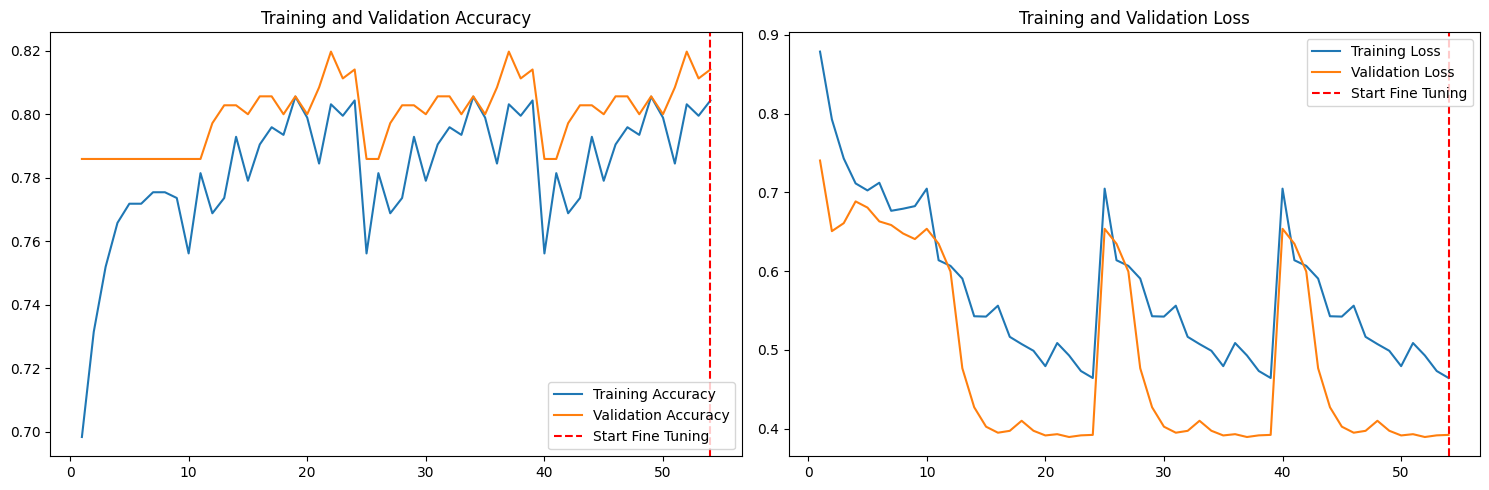

In [37]:
# Combine history from initial training and fine-tuning
def plot_history(initial_history, fine_tune_history=None):
    acc = initial_history.history['accuracy']
    val_acc = initial_history.history['val_accuracy']
    loss = initial_history.history['loss']
    val_loss = initial_history.history['val_loss']

    if fine_tune_history:
        acc += fine_tune_history.history['accuracy']
        val_acc += fine_tune_history.history['val_accuracy']
        loss += fine_tune_history.history['loss']
        val_loss += fine_tune_history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    if fine_tune_history:
        plt.axvline(x=len(initial_history.history['accuracy']), color='r', linestyle='--', label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    if fine_tune_history:
        plt.axvline(x=len(initial_history.history['loss']), color='r', linestyle='--', label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()

# Plot combined training history
plot_history(initial_history, fine_tune_history)

## Test the model with mammogram images

In [38]:
# Function to test the model with sample images
def test_sample_image(model, image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    confidence = predictions[0][class_idx] * 100

    class_names = list(train_data.class_indices.keys())
    class_name = list(train_data.class_indices.keys())[class_idx]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return class_name, confidence, predictions[0]


Testing sample from class: Malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


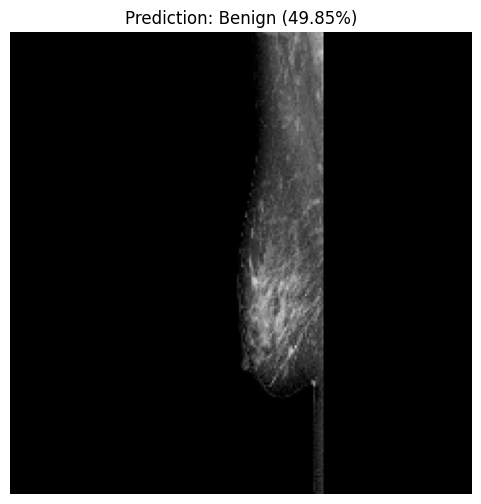

Predicted: Benign with 49.85% confidence
All probabilities: [0.498511   0.21012141 0.29136765]

Testing sample from class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


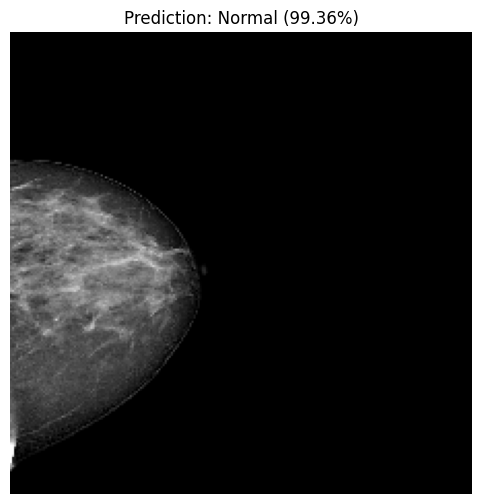

Predicted: Normal with 99.36% confidence
All probabilities: [0.00135485 0.00506107 0.9935841 ]

Testing sample from class: Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


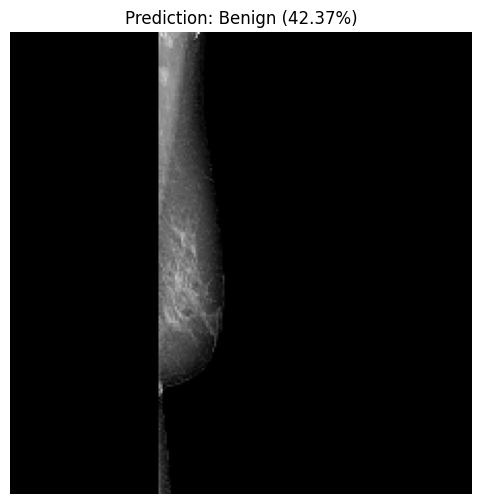

Predicted: Benign with 42.37% confidence
All probabilities: [0.42373163 0.22030964 0.35595873]


In [41]:
# Test with a sample from each class
for class_name in os.listdir('/content/test'):
    sample_images = os.listdir(f'/content/test/{class_name}')
    if sample_images:
        sample_path = f'/content/test/{class_name}/{sample_images[0]}'
        print(f"\nTesting sample from class: {class_name}")
        predicted_class, confidence, all_probs = test_sample_image(best_model, sample_path)
        print(f"Predicted: {predicted_class} with {confidence:.2f}% confidence")
        print(f"All probabilities: {all_probs}")